In [69]:
from vptree import *
import numpy as np
import random
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

### Define vectors of $n$ and $d$ to generate data sequence

In [70]:
ns = np.linspace(100, 10000, 50).astype(int)
ds = np.linspace(2, 100, 50).astype(int)
n_trials = len(ns)*len(ds)
n_queries = 50

df = lambda a, b : np.linalg.norm(a-b)
vpf = random.choice

### Build VP trees and linear scan objects

In [71]:
data_seq = [
    [np.random.rand(n, d) for d in ds] for n in ns
]
print("Generated data sequence...")

n_trees_built = 1
trees = []
for dims in data_seq:
    trees_fixed_n = []
    for data in dims:
        trees_fixed_n.append(VPTree(data, df, vpf))
        print("Built [{}/{}] trees...".format(n_trees_built, n_trials), end = "\r")
        sys.stdout.flush()
        n_trees_built += 1
    trees.append(trees_fixed_n)
print("Built VP trees...")

scans = [
    [LinearScan(data, df) for data in dims] for dims in data_seq
]
print("Built linear scan objects!")

Generated data sequence...
Built VP trees... trees...
Built linear scan objects!


### Query trees and generate results

In [72]:
print("Querying {}x{}={} trees... this may take a while".format(len(ns), len(ds), n_trials))
n_done = 1
results = np.zeros((len(ns), len(ds)))
for i, trees_fixed_n in enumerate(trees):
    for j, tree in enumerate(trees_fixed_n):
        scan = scans[i][j]
        n_correct = n_queries
        for k in range(n_queries):
            q = np.random.rand(ds[j])
            correct = (scan.get_rank_of(q, tree.fast_approx_query(q)) == 0)
            if not correct:
                n_correct -= 1
        results[i, j] = (n_correct / n_queries)
        print("Finished [{}/{}] trials...".format(n_done, n_trials), end = "\r")
        sys.stdout.flush()
        n_done += 1

Querying 50x50=2500 trees... this may take a while


### Plot results

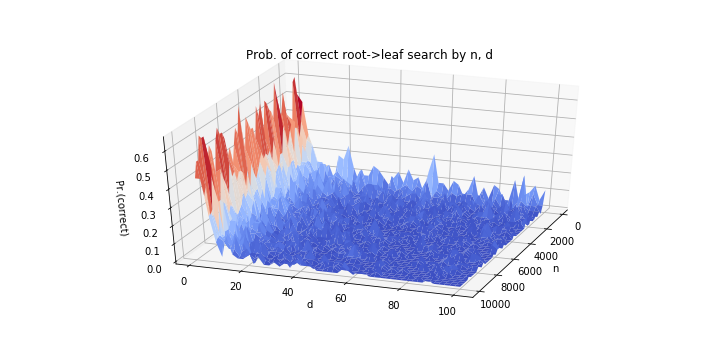

In [74]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

X, Y = np.meshgrid(ns, ds, indexing = "ij")
fig = plt.figure(figsize = (10, 5))
ax = fig.gca(projection = "3d")
surf = ax.plot_surface(X, Y, results, cmap = cm.coolwarm, linewidth = 0)
ax.set_xlabel("n")
ax.set_ylabel("d")
ax.set_zlabel("Pr.(correct)")
ax.view_init(elev = 35, azim = 20)
plt.title("Prob. of correct root->leaf search by n, d")
plt.savefig("correct_root_leaf_approx.png")
plt.show()

### Fit linear model to results

In [101]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

df = pd.DataFrame(results, index = ns, columns = ds)
df.reset_index(inplace = True)
df.rename(columns = {"index" : "n"}, inplace = True)
df = pd.melt(df, id_vars = ["n"], var_name = "d", value_name = "pct_correct")
print(df.head(5))

     n  d  pct_correct
0  100  2         0.52
1  302  2         0.62
2  504  2         0.60
3  706  2         0.36
4  908  2         0.42


In [158]:
Y = df["pct_correct"]
X = df[["n", "d"]]

def extract_features_nd(X):
    poly = PolynomialFeatures(2, include_bias = False)
    X = poly.fit_transform(X)
    fnames = poly.get_feature_names()
    fnames = [name.replace("x0", "n").replace("x1", "d") for name in fnames]

    log = FunctionTransformer(np.log, validate = False)
    X_log = log.fit_transform(X)
    log_fnames = ["log " + name for name in fnames]

    inv = FunctionTransformer(np.reciprocal, validate = False)
    X_inv = inv.fit_transform(X)
    inv_fnames = ["inv " + name for name in fnames]

    X_inv_log = inv.fit_transform(X_log)
    inv_log_fnames = ["inv log " + name for name in fnames]

    X_concat = np.concatenate((X, X_log), axis = 1)
    X_concat = np.concatenate((X_concat, X_inv), axis = 1)
    X_concat = np.concatenate((X_concat, X_inv_log), axis = 1)
    inter = PolynomialFeatures(2, interaction_only = True, include_bias = False)
    X_concat = inter.fit_transform(X_concat)
    fnames = inter.get_feature_names(fnames + log_fnames + inv_fnames + inv_log_fnames)
    
    return X_concat, fnames

X_concat, fnames = extract_features_nd(X)

(1, 210)


In [148]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 250)
rf.fit(X_concat, Y)
r2 = rf.score(X_concat, Y)
print("Coef. of determination: {0:.2f}".format(r2))

Coef. of determination: 0.99


In [149]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression(fit_intercept = False)
lm.fit(X_concat, Y)
r2 = lm.score(X_concat, Y)
print("Coef. of determination: {0:.2f}".format(r2))

Coef. of determination: 0.92


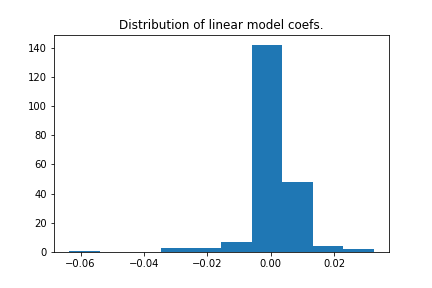

In [150]:
plt.hist(lm.coef_)
plt.title("Distribution of linear model coefs.")
plt.show()

In [151]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv = 10)
lasso.fit(X_concat, Y)
r2 = lasso.score(X_concat, Y)
print("Coef. of determination: {0:.2f}".format(r2))

Coef. of determination: 0.07


### Test usefulness of Random Forest regressor in picking num. trees to query in VP forest

In [182]:
np.random.seed(123)

n = int(10000*np.random.rand())
d = max(2, int(100*np.random.rand()))

n, d = 2500, 10

data = np.random.rand(n, d)
query_sequence = [np.random.rand(d) for q in range(n_queries)]

feats, __ = extract_features_nd(np.array([n, d]).reshape(1, 2))
p = rf.predict(feats)
print("Given n = {}, d = {}, probability of finding the NN in a root=>leaf search is {}".format(n, d, p))

Given n = 2500, d = 10, probability of finding the NN in a root=>leaf search is [0.07744]


Given a calculated value $p$ being the estimated probability that a given root-to-leaf search in a single VP tree in the VP forest will succeed, we can calculate the expected number of trees such that any query will succeed in the tree as follows. Let this number of trees be $m$. 

$$Pr.(\text{search in one tree fails}) = 1-p$$
$$\therefore Pr.(\text{search in all trees fails}) = (1-p)^m$$
$$\therefore Pr.(\text{search does not fail in at least one tree}) = 1 - (1-p)^m = \delta$$
$$\therefore 1 - \delta = (1-p)^m \implies \log(1-\delta) = m\log(1-p) \implies m^* = \frac{\log(1-\delta)}{\log(1-p)}$$

Where $\delta$ is a tunable *confidence* parameter. In this experiment, let $\delta = 3/4$, yielding $m^* = \lceil 45.5131 \rceil = 46$. So, if we run 50 queries on a VP forest generated over this data, we expected roughly 38 of them to succeed. Let's verify this. 

In [181]:
n_estimators = 46
n_estimators *= 2

df = lambda a, b : np.linalg.norm(a-b)
vpf = VPForest(data, df, n_estimators = n_estimators)
ls = LinearScan(data, df)

n_correct = 50
for i, q in enumerate(query_sequence):
    nn = vpf.query(q, n_trees = n_estimators)
    correct = (ls.get_rank_of(q, nn) == 0)
    if not correct:
        n_correct -= 1
print("With {} trees in the forest, the accuracy rate was {}/{}".format(n_estimators, n_correct, n_queries))

With 92 trees in the forest, the accuracy rate was 36/50


So, the forest does not quite perform as expected, needing roughly twice the number of predicted estimators to achieve the desired confidence bound. 